# Workshop 8 - Training Neural Networks (Learning rate scheduling and optimisers)

Code for workshop 8.  This will use Keras (within tensorflow v2)

In [1]:
# Common imports
import sys
import sklearn
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


## Load data
We will use MNIST, which is a set of small images (28x28) that contain 10 digits - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


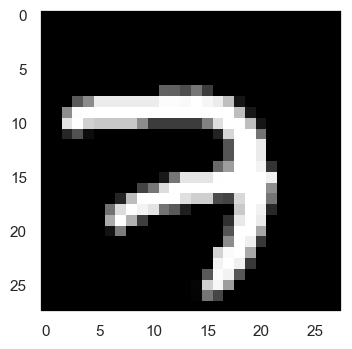

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

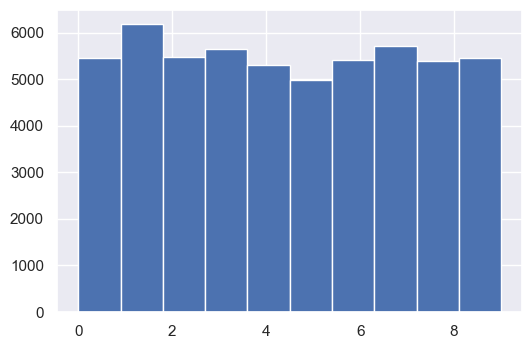

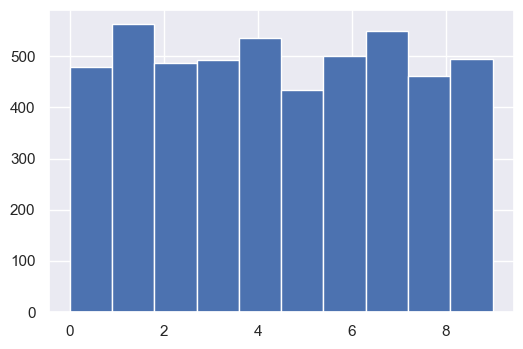

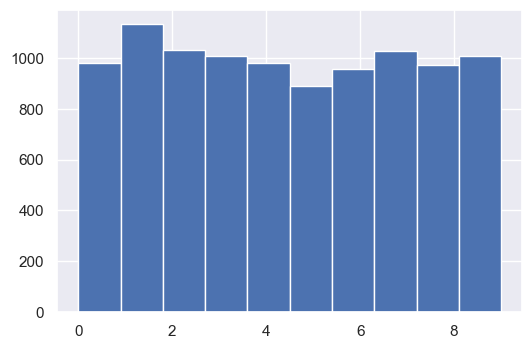

In [6]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [7]:
# Some key parameters
n_train = 300
n_valid = 100
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [8]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [9]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [10]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))  # Num of batches, xdim,ydim,channels
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [11]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # restore_best_weights keeps te weights of the best case.

In [12]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [13]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
10/10 [==============================] - 6s 63ms/step - loss: 2.3473 - accuracy: 0.0100 - val_loss: 2.3384 - val_accuracy: 0.0200
Epoch 2/20
10/10 [==============================] - 0s 24ms/step - loss: 2.3174 - accuracy: 0.0367 - val_loss: 2.3124 - val_accuracy: 0.0400
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 2.2920 - accuracy: 0.0933 - val_loss: 2.2888 - val_accuracy: 0.1100
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2680 - accuracy: 0.1667 - val_loss: 2.2664 - val_accuracy: 0.1600
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 2.2455 - accuracy: 0.1833 - val_loss: 2.2439 - val_accuracy: 0.2000
Epoch 6/20
10/10 [==============================] - 0s 21ms/step - loss: 2.2213 - accuracy: 0.2367 - val_loss: 2.2200 - val_accuracy: 0.2000
Epoch 7/20
10/10 [==============================] - 0s 23ms/step - loss: 2.1963 - accuracy: 0.2000 - val_loss: 2.1970 - val_accuracy: 0.2800
Epoch 8/20
10

In [14]:
# How you can get the parameters in a 2dConv?

# Parameters in a 2dConv layer
# ((kernel_height* kernel_width*number_inputs)+1)*num_kernels

# Example first Conv2d
print("Parameters in first Conv2D: ", ((3*3*1)+1)*16)

# Example second Conv2d
print("Parameters in second Conv2D: ", ((3*3*16)+1)*32)

Parameters in first Conv2D:  160
Parameters in second Conv2D:  4640


In [15]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    # Comment out the next line to see the loss and accuracy values properly
    # plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

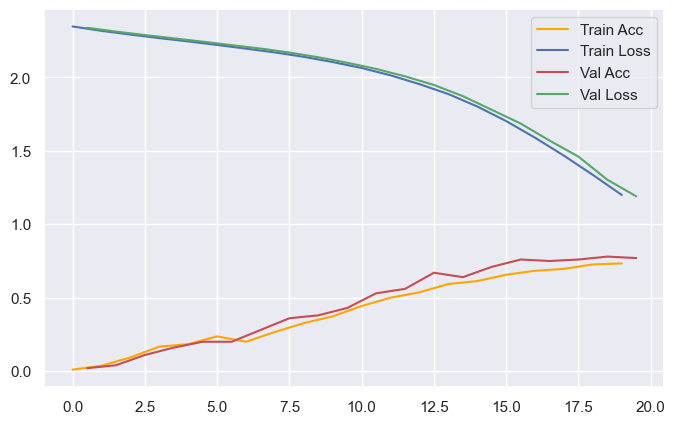

In [16]:
plot_history(history)

# Manually exploring the learning rate



Epoch 1/20
10/10 [==============================] - 1s 38ms/step - loss: 5249467678720.0000 - accuracy: 0.1167 - val_loss: 7799535828992.0000 - val_accuracy: 0.1400
Epoch 2/20
10/10 [==============================] - 0s 19ms/step - loss: 8039053131776.0000 - accuracy: 0.1100 - val_loss: 7799535828992.0000 - val_accuracy: 0.1400
Epoch 3/20
10/10 [==============================] - 0s 28ms/step - loss: 8039054704640.0000 - accuracy: 0.1100 - val_loss: 7799535828992.0000 - val_accuracy: 0.1400
Epoch 4/20
10/10 [==============================] - 0s 23ms/step - loss: 8039054180352.0000 - accuracy: 0.1100 - val_loss: 7799535828992.0000 - val_accuracy: 0.1400
Epoch 5/20
10/10 [==============================] - 0s 21ms/step - loss: 8039054180352.0000 - accuracy: 0.1100 - val_loss: 7799535828992.0000 - val_accuracy: 0.1400
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 8039054180352.0000 - accuracy: 0.1100 - val_loss: 7799535828992.0000 - val_accuracy: 0.1400


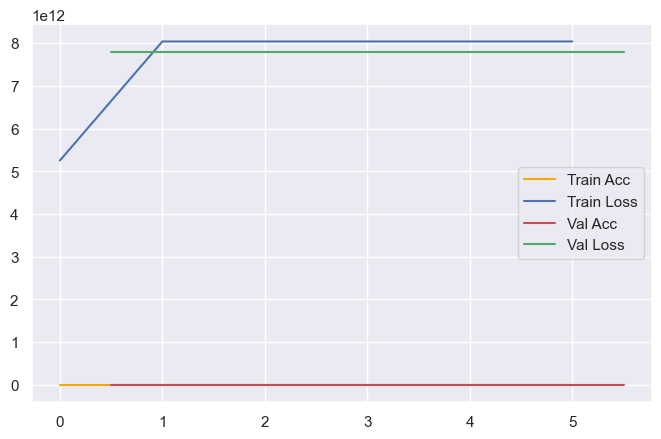

Epoch 1/20
10/10 [==============================] - 1s 39ms/step - loss: 2.2614 - accuracy: 0.1700 - val_loss: 2.1208 - val_accuracy: 0.4300
Epoch 2/20
10/10 [==============================] - 0s 21ms/step - loss: 1.9290 - accuracy: 0.4767 - val_loss: 1.8279 - val_accuracy: 0.2700
Epoch 3/20
10/10 [==============================] - 0s 28ms/step - loss: 1.2946 - accuracy: 0.5733 - val_loss: 1.0637 - val_accuracy: 0.6500
Epoch 4/20
10/10 [==============================] - 0s 22ms/step - loss: 0.7274 - accuracy: 0.7933 - val_loss: 0.8786 - val_accuracy: 0.7100
Epoch 5/20
10/10 [==============================] - 0s 21ms/step - loss: 0.5348 - accuracy: 0.8500 - val_loss: 0.7034 - val_accuracy: 0.7600
Epoch 6/20
10/10 [==============================] - 0s 21ms/step - loss: 0.5064 - accuracy: 0.8500 - val_loss: 0.5405 - val_accuracy: 0.8600
Epoch 7/20
10/10 [==============================] - 0s 23ms/step - loss: 0.3075 - accuracy: 0.9133 - val_loss: 0.4964 - val_accuracy: 0.8700
Epoch 8/20
10

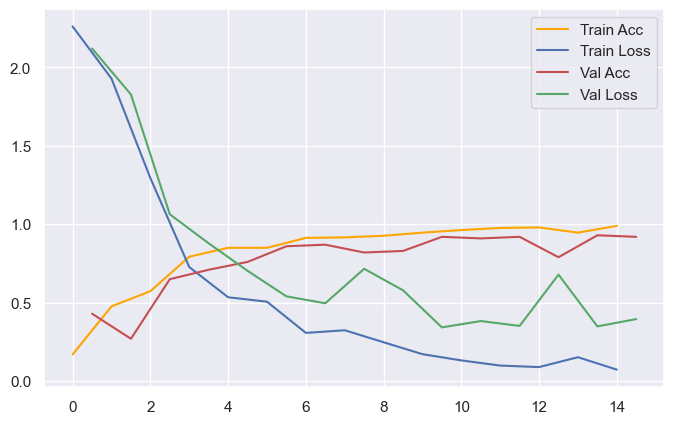

Epoch 1/20
10/10 [==============================] - 1s 43ms/step - loss: 2.3012 - accuracy: 0.1133 - val_loss: 2.2819 - val_accuracy: 0.1300
Epoch 2/20
10/10 [==============================] - 0s 22ms/step - loss: 2.2817 - accuracy: 0.1633 - val_loss: 2.2657 - val_accuracy: 0.1500
Epoch 3/20
10/10 [==============================] - 0s 22ms/step - loss: 2.2634 - accuracy: 0.2133 - val_loss: 2.2497 - val_accuracy: 0.1500
Epoch 4/20
10/10 [==============================] - 0s 20ms/step - loss: 2.2448 - accuracy: 0.2733 - val_loss: 2.2330 - val_accuracy: 0.2000
Epoch 5/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2261 - accuracy: 0.3133 - val_loss: 2.2162 - val_accuracy: 0.2700
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2064 - accuracy: 0.3533 - val_loss: 2.1977 - val_accuracy: 0.3100
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 2.1857 - accuracy: 0.3833 - val_loss: 2.1768 - val_accuracy: 0.3800
Epoch 8/20
10

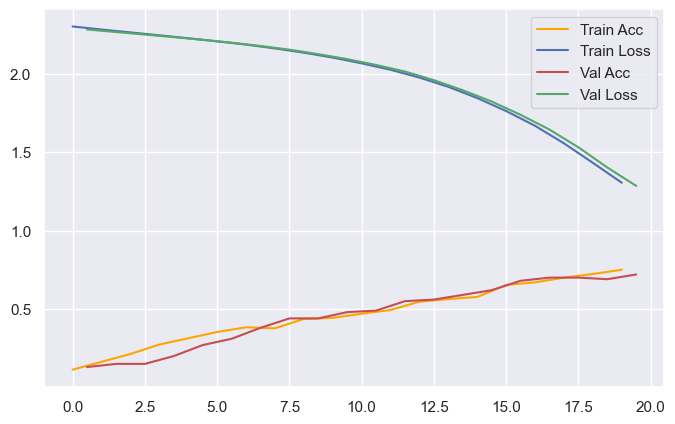

Epoch 1/20
10/10 [==============================] - 1s 43ms/step - loss: 2.2914 - accuracy: 0.1600 - val_loss: 2.2612 - val_accuracy: 0.2000
Epoch 2/20
10/10 [==============================] - 0s 23ms/step - loss: 2.2880 - accuracy: 0.1600 - val_loss: 2.2585 - val_accuracy: 0.2000
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 2.2848 - accuracy: 0.1667 - val_loss: 2.2556 - val_accuracy: 0.2000
Epoch 4/20
10/10 [==============================] - 0s 21ms/step - loss: 2.2814 - accuracy: 0.1700 - val_loss: 2.2530 - val_accuracy: 0.2000
Epoch 5/20
10/10 [==============================] - 0s 23ms/step - loss: 2.2783 - accuracy: 0.1700 - val_loss: 2.2503 - val_accuracy: 0.2000
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2751 - accuracy: 0.1800 - val_loss: 2.2475 - val_accuracy: 0.2000
Epoch 7/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2718 - accuracy: 0.1900 - val_loss: 2.2450 - val_accuracy: 0.2000
Epoch 8/20
10

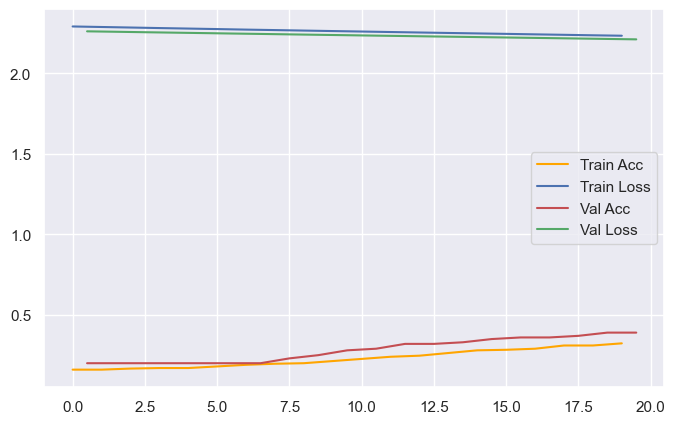

[[1, 0.14000000059604645], [0.1, 0.9300000071525574], [0.01, 0.7200000286102295], [0.001, 0.38999998569488525]]


In [17]:
# Learning rate
learning_rates=[1,0.1,0.01,0.001]
# Save the results
res = []
for lr in learning_rates:
    valacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[lr,valacc]]
print(res)

Text(0, 0.5, 'Val Accuracy')

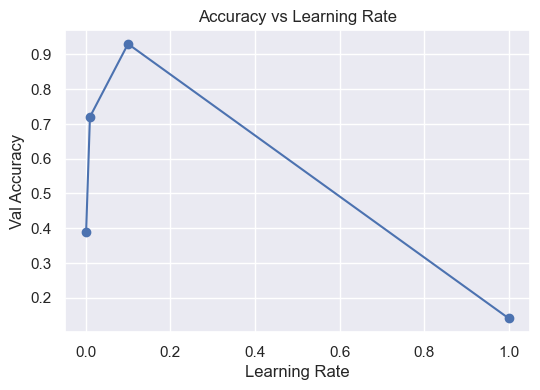

In [18]:
# We can check how the performance varies in function to the learning rate
res=np.array(res)
plt.plot(res[:,0],res[:,1],'bo')
plt.plot(res[:,0],res[:,1])
plt.title('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Val Accuracy')

Epoch 1/20
10/10 [==============================] - 1s 34ms/step - loss: 2.2956 - accuracy: 0.1333 - val_loss: 2.2587 - val_accuracy: 0.2500
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2424 - accuracy: 0.2367 - val_loss: 2.2092 - val_accuracy: 0.3200
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 2.1889 - accuracy: 0.3133 - val_loss: 2.1543 - val_accuracy: 0.3900
Epoch 4/20
10/10 [==============================] - 0s 22ms/step - loss: 2.1265 - accuracy: 0.4000 - val_loss: 2.0884 - val_accuracy: 0.4700
Epoch 5/20
10/10 [==============================] - 0s 21ms/step - loss: 2.0531 - accuracy: 0.4200 - val_loss: 2.0073 - val_accuracy: 0.5400
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 1.9635 - accuracy: 0.4967 - val_loss: 1.9078 - val_accuracy: 0.6200
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 1.8456 - accuracy: 0.6200 - val_loss: 1.7786 - val_accuracy: 0.6600
Epoch 8/20
10

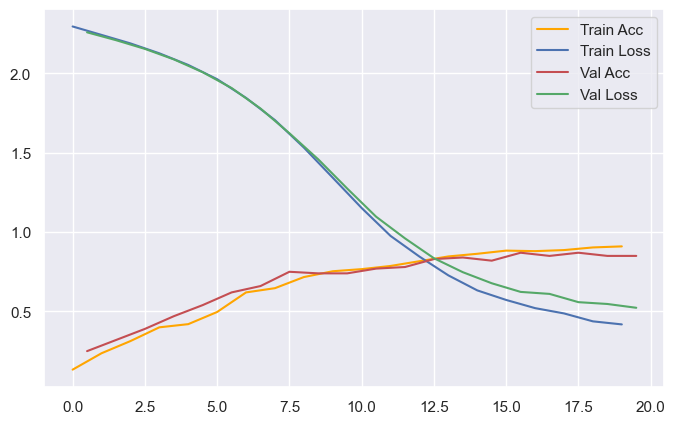

Epoch 1/20
10/10 [==============================] - 1s 34ms/step - loss: 2.3003 - accuracy: 0.1133 - val_loss: 2.1897 - val_accuracy: 0.3300
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 2.1679 - accuracy: 0.3267 - val_loss: 2.0667 - val_accuracy: 0.4800
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 2.0372 - accuracy: 0.4467 - val_loss: 1.9375 - val_accuracy: 0.6200
Epoch 4/20
10/10 [==============================] - 0s 20ms/step - loss: 1.8860 - accuracy: 0.5433 - val_loss: 1.7845 - val_accuracy: 0.7300
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 1.7074 - accuracy: 0.7000 - val_loss: 1.6096 - val_accuracy: 0.7500
Epoch 6/20
10/10 [==============================] - 0s 22ms/step - loss: 1.4980 - accuracy: 0.7667 - val_loss: 1.3839 - val_accuracy: 0.7600
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 1.2827 - accuracy: 0.7200 - val_loss: 1.2164 - val_accuracy: 0.7400
Epoch 8/20
10

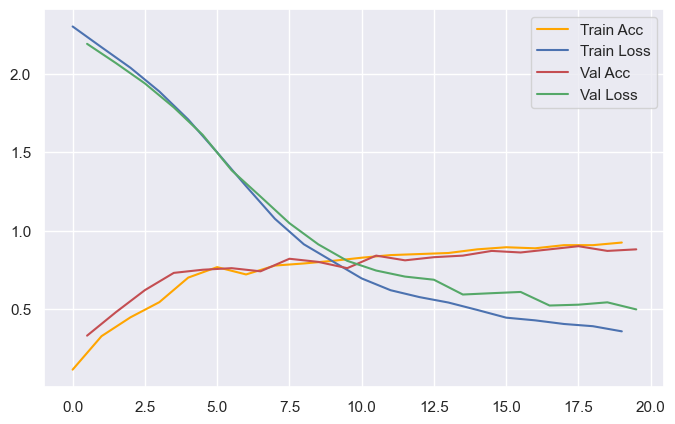

Epoch 1/20
10/10 [==============================] - 1s 38ms/step - loss: 2.2878 - accuracy: 0.1367 - val_loss: 2.2839 - val_accuracy: 0.1700
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2603 - accuracy: 0.1567 - val_loss: 2.2582 - val_accuracy: 0.1900
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2347 - accuracy: 0.2333 - val_loss: 2.2353 - val_accuracy: 0.2100
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2097 - accuracy: 0.2667 - val_loss: 2.2101 - val_accuracy: 0.2300
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 2.1826 - accuracy: 0.2600 - val_loss: 2.1823 - val_accuracy: 0.2900
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 2.1524 - accuracy: 0.3133 - val_loss: 2.1504 - val_accuracy: 0.3300
Epoch 7/20
10/10 [==============================] - 0s 18ms/step - loss: 2.1175 - accuracy: 0.3700 - val_loss: 2.1138 - val_accuracy: 0.3600
Epoch 8/20
10

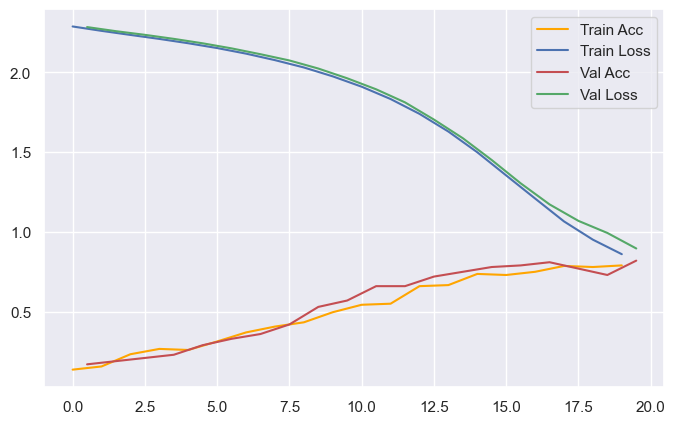

Epoch 1/20
10/10 [==============================] - 1s 35ms/step - loss: 2.3216 - accuracy: 0.0900 - val_loss: 2.2954 - val_accuracy: 0.1300
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2795 - accuracy: 0.1467 - val_loss: 2.2542 - val_accuracy: 0.2300
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2426 - accuracy: 0.2333 - val_loss: 2.2195 - val_accuracy: 0.2600
Epoch 4/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2088 - accuracy: 0.2533 - val_loss: 2.1847 - val_accuracy: 0.2800
Epoch 5/20
10/10 [==============================] - 0s 18ms/step - loss: 2.1742 - accuracy: 0.2800 - val_loss: 2.1471 - val_accuracy: 0.3000
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 2.1350 - accuracy: 0.2800 - val_loss: 2.1031 - val_accuracy: 0.3600
Epoch 7/20
10/10 [==============================] - 0s 18ms/step - loss: 2.0887 - accuracy: 0.3200 - val_loss: 2.0521 - val_accuracy: 0.4200
Epoch 8/20
10

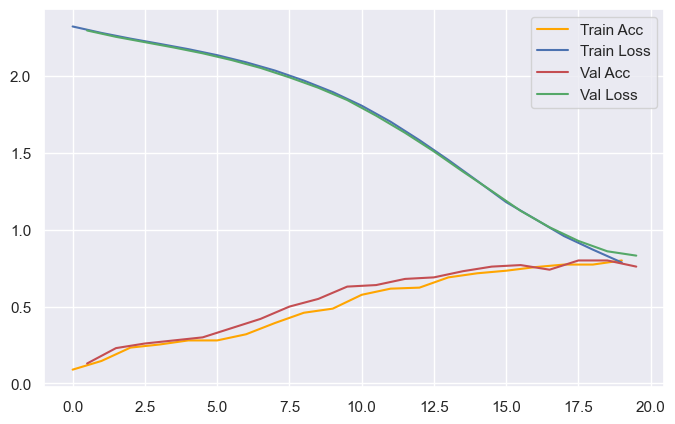

Epoch 1/20
10/10 [==============================] - 1s 36ms/step - loss: 2.3126 - accuracy: 0.0833 - val_loss: 2.2859 - val_accuracy: 0.2100
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2827 - accuracy: 0.1567 - val_loss: 2.2612 - val_accuracy: 0.2100
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 2.2560 - accuracy: 0.2167 - val_loss: 2.2376 - val_accuracy: 0.2300
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2290 - accuracy: 0.2333 - val_loss: 2.2123 - val_accuracy: 0.2800
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 2.2017 - accuracy: 0.2833 - val_loss: 2.1854 - val_accuracy: 0.3400
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 2.1728 - accuracy: 0.3367 - val_loss: 2.1546 - val_accuracy: 0.4100
Epoch 7/20
10/10 [==============================] - 0s 19ms/step - loss: 2.1372 - accuracy: 0.3833 - val_loss: 2.1202 - val_accuracy: 0.4400
Epoch 8/20
10

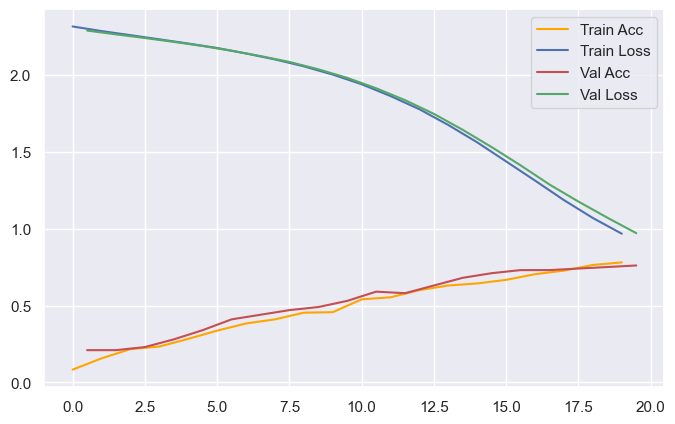

[[1, 0.8700000047683716], [2, 0.8999999761581421], [3, 0.8199999928474426], [5, 0.800000011920929], [10, 0.7599999904632568]]


In [19]:
# Number of layers
hidden_layers=[1,2,3,5,10]
# Save the results
res = []
for n in hidden_layers:
    valacc, history, discard = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc]]
print(res)

Text(0, 0.5, 'Val Accuracy')

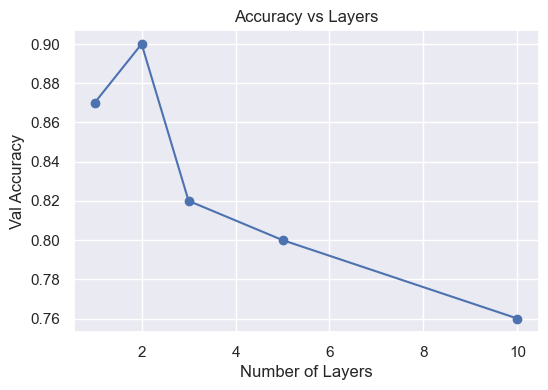

In [20]:
# We can plot the results of the performance vs the number of convolutional hidden layers
res=np.array(res)
plt.plot(res[:,0],res[:,1],'bo')
plt.plot(res[:,0],res[:,1])
plt.title('Accuracy vs Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Val Accuracy')

# Exploring optimizers

Let us compare different optimizers on the same task.

Epoch 1/20
10/10 [==============================] - 1s 37ms/step - loss: 2.3025 - accuracy: 0.1133 - val_loss: 2.2812 - val_accuracy: 0.1700
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 2.2735 - accuracy: 0.1900 - val_loss: 2.2545 - val_accuracy: 0.2700
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 2.2464 - accuracy: 0.2400 - val_loss: 2.2282 - val_accuracy: 0.2900
Epoch 4/20
10/10 [==============================] - 0s 23ms/step - loss: 2.2179 - accuracy: 0.2467 - val_loss: 2.2013 - val_accuracy: 0.3100
Epoch 5/20
10/10 [==============================] - 0s 25ms/step - loss: 2.1891 - accuracy: 0.2633 - val_loss: 2.1710 - val_accuracy: 0.3600
Epoch 6/20
10/10 [==============================] - 0s 22ms/step - loss: 2.1532 - accuracy: 0.3067 - val_loss: 2.1340 - val_accuracy: 0.4000
Epoch 7/20
10/10 [==============================] - 0s 19ms/step - loss: 2.1142 - accuracy: 0.2967 - val_loss: 2.0895 - val_accuracy: 0.4500
Epoch 8/20
10

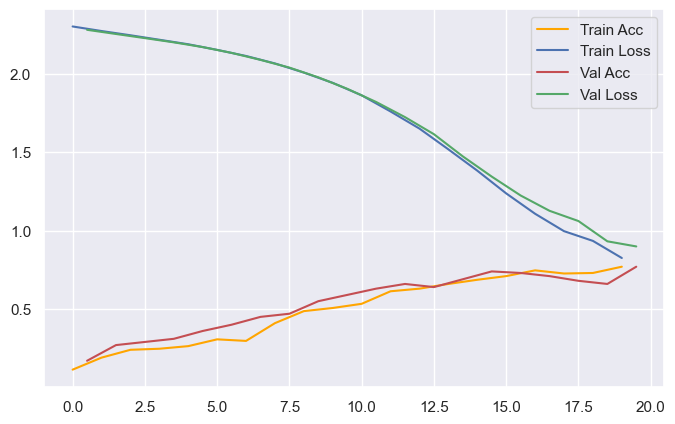

Epoch 1/20
10/10 [==============================] - 1s 39ms/step - loss: 6.5437 - accuracy: 0.1900 - val_loss: 2.2030 - val_accuracy: 0.3500
Epoch 2/20
10/10 [==============================] - 0s 21ms/step - loss: 0.9777 - accuracy: 0.6833 - val_loss: 0.8819 - val_accuracy: 0.7500
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 0.5880 - accuracy: 0.8233 - val_loss: 0.8270 - val_accuracy: 0.7400
Epoch 4/20
10/10 [==============================] - 0s 20ms/step - loss: 0.5291 - accuracy: 0.8133 - val_loss: 0.6331 - val_accuracy: 0.8000
Epoch 5/20
10/10 [==============================] - 0s 21ms/step - loss: 0.3607 - accuracy: 0.8900 - val_loss: 0.4699 - val_accuracy: 0.8600
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2246 - accuracy: 0.9367 - val_loss: 0.3198 - val_accuracy: 0.9400
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 0.1813 - accuracy: 0.9333 - val_loss: 0.5162 - val_accuracy: 0.8700
Epoch 8/20
10

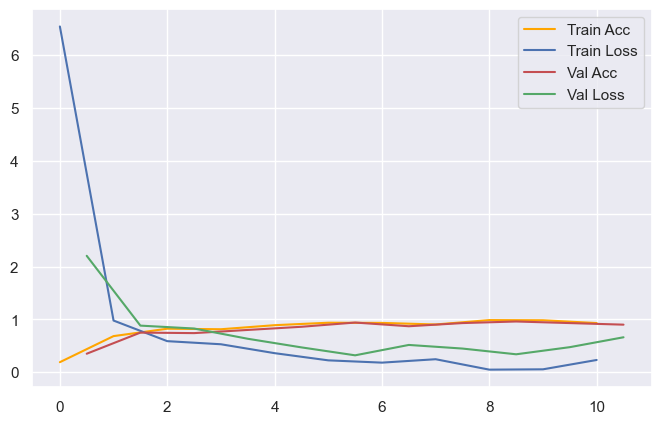

Epoch 1/20
10/10 [==============================] - 1s 42ms/step - loss: 1.7419 - accuracy: 0.4800 - val_loss: 0.8294 - val_accuracy: 0.7100
Epoch 2/20
10/10 [==============================] - 0s 19ms/step - loss: 0.7444 - accuracy: 0.8000 - val_loss: 0.5111 - val_accuracy: 0.8500
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 0.4260 - accuracy: 0.8700 - val_loss: 0.3658 - val_accuracy: 0.9000
Epoch 4/20
10/10 [==============================] - 0s 23ms/step - loss: 0.2157 - accuracy: 0.9267 - val_loss: 0.4502 - val_accuracy: 0.8800
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0880 - accuracy: 0.9667 - val_loss: 0.5243 - val_accuracy: 0.9300
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0845 - accuracy: 0.9700 - val_loss: 0.7124 - val_accuracy: 0.8900
Epoch 7/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0722 - accuracy: 0.9800 - val_loss: 0.5194 - val_accuracy: 0.9100
Epoch 8/20
10

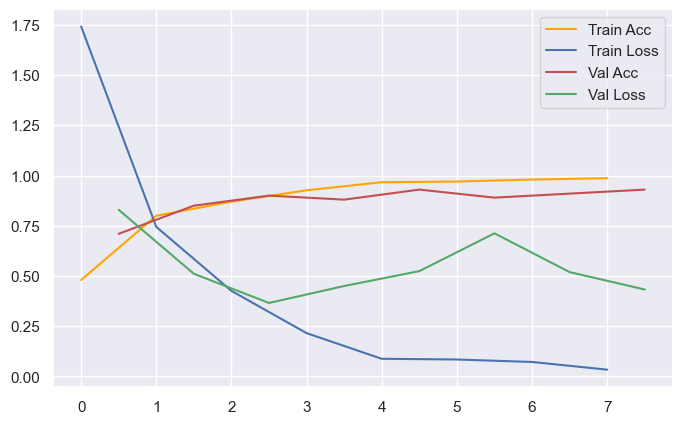

[[<class 'keras.optimizers.sgd.SGD'>, 0.7699999809265137], [<class 'keras.optimizers.rmsprop.RMSprop'>, 0.9599999785423279], [<class 'keras.optimizers.adam.Adam'>, 0.9300000071525574]]


In [21]:
# Number of layers
optimizers=[[keras.optimizers.SGD,0.01],[keras.optimizers.RMSprop,0.01],[keras.optimizers.Adam,0.01]]
# Save the results
res = []
for optimizer,lr in optimizers:
    valacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[optimizer,valacc]]
print(res)

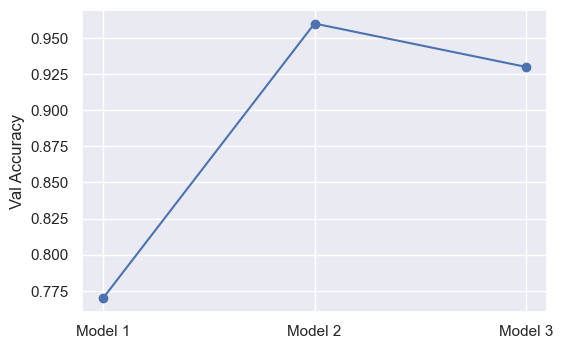

In [22]:
# Check our results
res=np.array(res)
plt.plot(['Model '+ str(x) for x in range(1,len(res)+1)],res[:,1],'bo')
plt.plot(['Model '+ str(x) for x in range(1,len(res)+1)],res[:,1])
plt.ylabel('Val Accuracy')
plt.show()

# Your Tasks

Which one has the best final classifier? 

Which one converges fastest? 

Which learning curve is the smoothest?

Which one would you choose?

# Exploring learning rate schedules

Let us compare different learning rate schedules on the same task.

Epoch 1/50
10/10 [==============================] - 2s 36ms/step - loss: 2.3154 - accuracy: 0.1233 - val_loss: 2.3095 - val_accuracy: 0.1400 - lr: 1.0000e-05
Epoch 2/50
10/10 [==============================] - 0s 19ms/step - loss: 2.3129 - accuracy: 0.1233 - val_loss: 2.3062 - val_accuracy: 0.1400 - lr: 1.5849e-05
Epoch 3/50
10/10 [==============================] - 0s 20ms/step - loss: 2.3083 - accuracy: 0.1333 - val_loss: 2.3004 - val_accuracy: 0.1500 - lr: 2.5119e-05
Epoch 4/50
10/10 [==============================] - 0s 19ms/step - loss: 2.3007 - accuracy: 0.1433 - val_loss: 2.2911 - val_accuracy: 0.1500 - lr: 3.9811e-05
Epoch 5/50
10/10 [==============================] - 0s 20ms/step - loss: 2.2887 - accuracy: 0.1467 - val_loss: 2.2767 - val_accuracy: 0.1600 - lr: 6.3096e-05
Epoch 6/50
10/10 [==============================] - 0s 24ms/step - loss: 2.2701 - accuracy: 0.1733 - val_loss: 2.2531 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 7/50
10/10 [==============================] - 

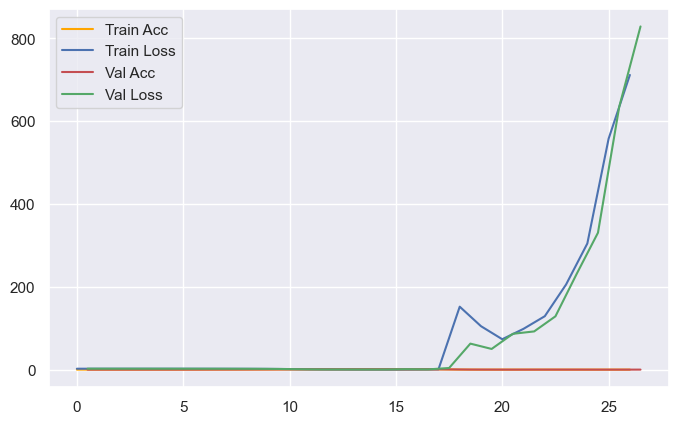

In [23]:
# Define scheduler functions
def exp_schedule(epoch):
    stretch=5
    return 0.00001 * (10**(epoch/stretch))

early_stopping_cb2 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True) 

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exp_schedule)
valacc, history, discard = do_all(hiddensizes, actfn, optimizer, learningrate, 
                                           n_train, n_valid, 50, batch_size,
                                           [lr_scheduler,early_stopping_cb2])
plot_history(history)

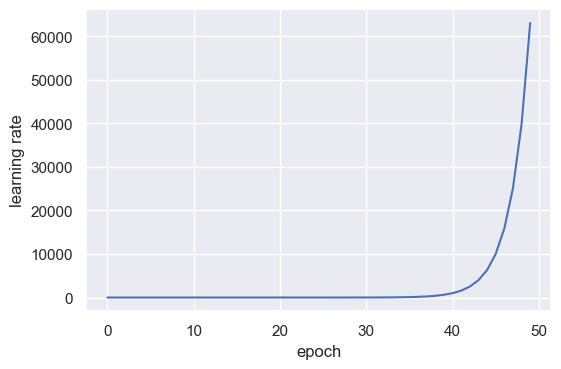

In [24]:
# Check the evolution of our learning rate
lrs=[]
for n in range(50):
        lrs = lrs + [exp_schedule(n)]
plt.plot(lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.show()

In [25]:
# Define a max learning rate for OneCycleSchedule (next cell)
maxlr=exp_schedule(22)
print(maxlr)

0.25118864315095824


Epoch 1/20
10/10 [==============================] - 2s 36ms/step - loss: 2.4544 - accuracy: 0.2133 - val_loss: 8.7910 - val_accuracy: 0.1100 - lr: 0.0251
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 91.0636 - accuracy: 0.0767 - val_loss: 93.4660 - val_accuracy: 0.1100 - lr: 0.0477
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 285.5685 - accuracy: 0.1200 - val_loss: 217.3651 - val_accuracy: 0.0800 - lr: 0.0703
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 164.3943 - accuracy: 0.1000 - val_loss: 98.1357 - val_accuracy: 0.0500 - lr: 0.0929
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 60.7652 - accuracy: 0.0967 - val_loss: 34.2094 - val_accuracy: 0.0800 - lr: 0.1155
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 39.0961 - accuracy: 0.1133 - val_loss: 43.6152 - val_accuracy: 0.1400 - lr: 0.1382
Epoch 7/20
10/10 [==============================] - 0s 22ms/ste

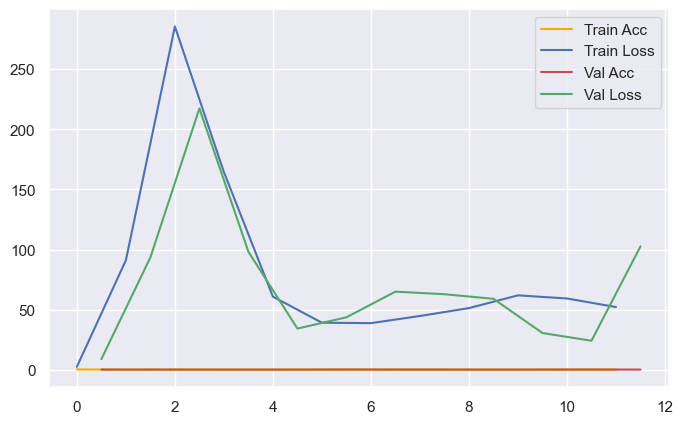

In [26]:
# Define scheduler functions
def OneCycleSchedule(epoch):
    maxepoch=20
    if epoch<maxepoch/2:
        lr=maxlr*(0.1 + (0.9*epoch/(maxepoch/2)))
    elif epoch<maxepoch:
        lr=maxlr*(1.9-0.9*epoch/(maxepoch/2))
    else:
        lr=0.1*maxlr
    return lr

early_stopping_cb3 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True) 

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler2 = tf.keras.callbacks.LearningRateScheduler(OneCycleSchedule)
valacc, history, discard = do_all(hiddensizes, actfn, optimizer, learningrate, 
                                           n_train, n_valid, n_epochs, batch_size,
                                           [lr_scheduler2,early_stopping_cb3])
plot_history(history)

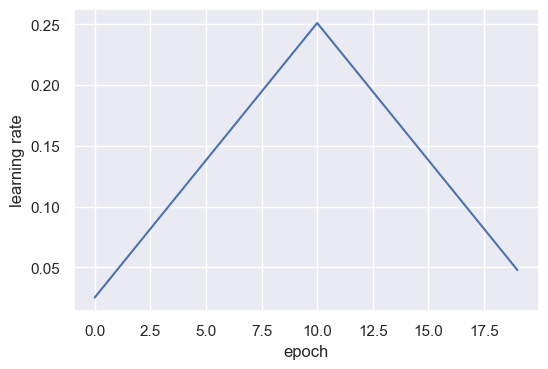

In [27]:
# We can check the evolution of our learning rate
lrs=[]
for n in range(n_epochs):
        lrs = lrs + [OneCycleSchedule(n)]
plt.plot(lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.show()

# Your Tasks: 

Write a new learning rate scheduler (copy from above and edit) that does a simple '1cycle' scheduling. Use the manual learning rate tests above *but with the Nadam optimizer* to choose a maximum learning rate. 

Manually experiment with the number of iterations for the upslope/down slope. 

Is the convergence faster than with a fixed learning rate?